In [1]:
import pandas as pd
import sqlite3

%matplotlib inline

In [2]:
def run_query(query, table='chinook.db'):
    with sqlite3.connect(table) as conn:
        return pd.read_sql(query, conn)

def run_command(command, table='chinook.db'):
    with sqlite3.connect(table) as conn:
        conn.isolation_level = None
        conn.execute(command)
        
def show_tables():
    query = """
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    """
    return run_query(query)

In [3]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Look for the most popular genres

In [4]:
query = """
with total_sold_cte as (
    select sum(invoice_line.quantity) as total
    from invoice_line
)
select 
    g.name as genre,
    sum(il.quantity) as tracks_sold,
    cast(sum(il.quantity) as float) / (select * from total_sold_cte) * 100 as percentage 
from genre g
join track t on t.genre_id = g.genre_id
join invoice_line il on il.track_id = t.track_id
group by g.name
order by tracks_sold desc
"""
genre_df = run_query(query)
genre_df.set_index('genre', drop=True, inplace=True)

In [5]:
genre_df.head()

,tracks_sold,percentage
genre,,
Rock,2635,55.392054
Metal,619,13.012403
Alternative & Punk,492,10.342653
Latin,167,3.510616
R&B/Soul,159,3.342443


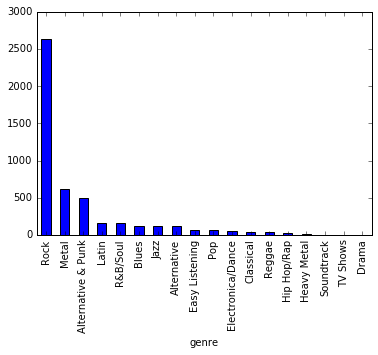

In [6]:
genre_df['tracks_sold'].plot.bar()

The most popular genres are Rock, Metal and Alternative & Punk, according to the provided data.

# Look for the most valuable salesman

In [7]:
query = """
with sales as (
    select
        e.first_name || " " || e.last_name as employee_name,
        sum(i.total) as total_revenue,
        count(i.invoice_id) as total_sales,
        (julianday('now') - julianday(e.hire_date)) as days_employeed
    from invoice i
    left join customer c on i.customer_id = c.customer_id
    left join employee e on e.employee_id = c.support_rep_id
    group by employee_name
    )
select 
    s.*,
    cast(s.total_revenue as float) / s.days_employeed as daily_revenue,
    cast(s.total_sales as float) / s.days_employeed as daily_sales
from sales s;
"""
sales_df = run_query(query)
sales_df.set_index('employee_name', drop=True, inplace=True)

In [8]:
sales_df.head(10)

,total_revenue,total_sales,days_employeed,daily_revenue,daily_sales
employee_name,,,,,
Jane Peacock,1731.51,212,373.714805,4.633239,0.567277
Margaret Park,1584.00,214,341.714805,4.635444,0.626253
Steve Johnson,1393.92,188,174.714805,7.978259,1.076039


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b44099630>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f5ae215c518>], dtype=object)

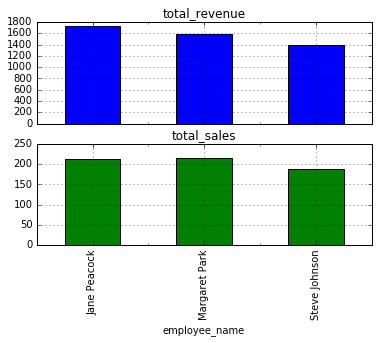

In [9]:
sales_df[['total_revenue', 'total_sales']].plot(kind='bar',grid=True,subplots=True,sharex=True,legend=False) 

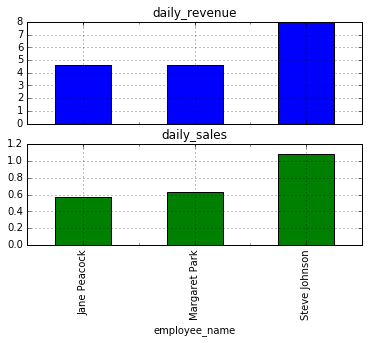

In [10]:
sales_df[['daily_revenue','daily_sales']].plot(kind='bar',grid=True,subplots=True,sharex=True,legend=False); 

The most profitable sales manager so far was Jane Peacock, but that can be explained by the fact that she works at that place longer than anybody.

The most promising sales manager is Steve Johnson, who has the lowest total revenue due to the recent employment, but his daily stats are double of other employees.

# Analyzing the sales data for customers from every country

In [11]:
query="""
with countries_cte as (
    select 
        c.country,
        count(c.customer_id) as number_of_customers,
        sum(i.total) as total_revenue,
        avg(i.total) as avg_revenue_per_customer,
        cast(avg(il.unit_price) as float) as avg_order_value
    from customer c
    join invoice i on c.customer_id = i.customer_id
    join invoice_line il on i.invoice_id = il.invoice_id
    group by c.country
),
countries_sorted_cte as (
    select 
        c.*,
        case 
            when c.number_of_customers < 2 then 1
            else 0
        end as sort
    from countries_cte c
)
 
select 
    c.*
from countries_sorted_cte cs
join countries_cte c on cs.country = c.country
order by cs.sort, c.total_revenue desc;
"""
countries_df = run_query(query)
countries_df.set_index('country', drop=True, inplace=True)
#had to deal with some bug
countries_df['avg_order_value'] = countries_df['avg_order_value'].astype('str').astype('float')

In [12]:
countries_df.head(10)

,number_of_customers,total_revenue,avg_revenue_per_customer,avg_order_value
country,,,,
USA,1051,10405.89,9.900942,0.99
Canada,541,5489.55,10.147043,0.99
Brazil,432,4059.00,9.395833,0.99
France,393,3972.87,10.109084,0.99
Germany,338,3441.24,10.181183,0.99
Czech Republic,276,3183.84,11.535652,0.99
United Kingdom,248,2498.76,10.075645,0.99
India,185,1887.93,10.205027,0.99
Portugal,187,1755.27,9.386471,0.99


In [13]:
countries_df.shape

(24, 4)

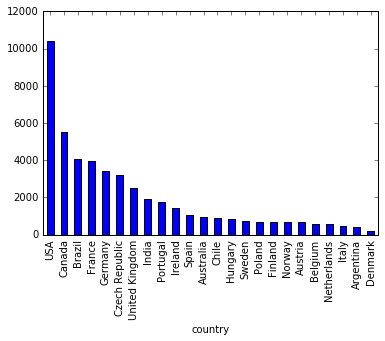

In [14]:
countries_df['total_revenue'].plot.bar()
#countries_df[['number_of_customers','total_revenue']].plot(kind='bar',grid=False,subplots=True,sharex=True,legend=False); 

In [15]:
countries_df['avg_order_value'].value_counts()

0.99    24
Name: avg_order_value, dtype: int64

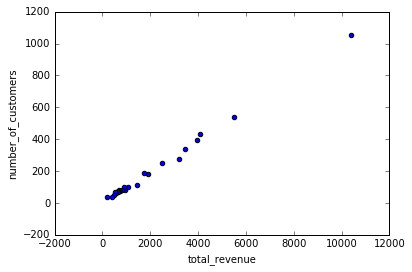

In [16]:
countries_df.plot(x='total_revenue',y='number_of_customers',kind='scatter')

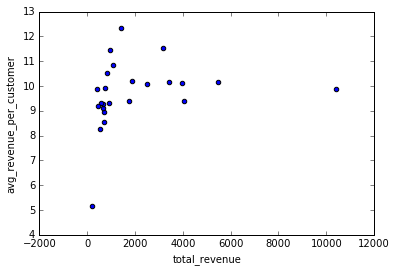

In [17]:
countries_df.plot(x='total_revenue',y='avg_revenue_per_customer',kind='scatter')

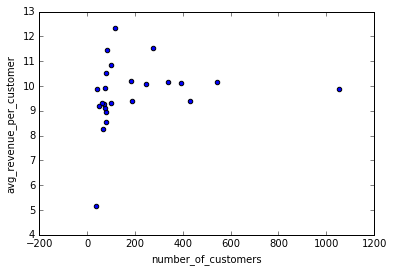

In [18]:
countries_df.plot(x='number_of_customers',y='avg_revenue_per_customer',kind='scatter')

In [19]:
correlations = countries_df.corr().round(4)
correlations = correlations["total_revenue"]
print(correlations)

number_of_customers         0.9981
total_revenue               1.0000
avg_revenue_per_customer    0.2291
avg_order_value            -0.0000
Name: total_revenue, dtype: float64


The most profitable countries are USA, Canada, Brazil, France and Germany.

There is a huge correlation between number of customers and total revenue (obviously), and a positive correlation between average revenue per customer and total revenue.

# Analyzing what to prefer: selling individual tracks or selling albums

In [26]:
query="""
select 
    il.track_id
from invoice i
left join invoice_line il on il.invoice_id = i.invoice_id
--group by i.invoice_id
"""
test_df = run_query(query)
test_df.head(10)

,track_id
0,2160
1,875
2,83
3,16
4,1756
5,3460
6,93
7,24
8,21
9,15


In [27]:
test_df.shape

(4757, 1)